# CatBoost models creating for calculate body fat percentage


## Materials

We used a ready-made dataframe `main_work.ipynb` without outliers for most characteristics, one for two genders, age 18-22 - `df_`.

In [1]:
# Work with data
import itertools
import numpy as np
import math as mth

# Dataframe
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Statistical
from scipy import stats as st
import sklearn
from scipy.stats import pearsonr

In [3]:
df_ = pd.read_csv("data_for_analysis.csv")
df_.drop (df_.columns[[0,1]], axis= 1, inplace= True)
df_.drop (index=217, inplace= True)
df_.head()

number city_exam  date_birth   date_exam  age  sex  phase_angle   BMI  \
0    89.0    москва  2003-12-06  2023-09-21   19    1          NaN  24.2   
1    98.0    москва  2005-08-31  2023-09-22   18    1          NaN  19.4   
2    75.0    москва  2005-04-10  2023-09-21   18    1          NaN  27.4   
3    53.0    москва  2004-08-20  2023-09-19   19    1          NaN  24.2   
4    83.0    москва  2003-12-01  2023-09-21   19    1          NaN  21.5   

   Fat_mass  FM_share  ...  Diastolic_BP    HR  FEV1   FVC  FEV1/FVC  \
0      13.0      17.9  ...          63.0  63.0  3.65  3.58     102.0   
1      12.7      19.6  ...          78.0  84.0  2.94  3.01      98.0   
2      18.3      21.5  ...          73.0  64.0  4.55  4.61      99.0   
3      15.1      21.1  ...          81.0  84.0  3.20  3.14     102.0   
4      15.0      21.9  ...          78.0  81.0  3.83  3.75     102.0   

   airflow_speed  father_nationality  mother_nationality  city_birth  sex_  
0          10.53                 рус                 рус      мытищи   men  
1           5.42                 рус                 рус      москва   men  
2           9.88                 рус                 рус      москва   men  
3           6.17                 рус                 рус      москва   men  
4           8.45                 рус                 рус      москва   men  

[5 rows x 59 columns]

In [4]:
feat_names = pd.read_excel("feat_names.xlsx")
feat_names

basic                  correct
0               BMI          Body mass index
1          Fat_mass                 Fat mass
2          FM_share      Percentage body fat
3         Body_mass                   Weight
4            vertex                   Height
5     suprasternale  Height of suprasternale
6          acromion       Height of acromion
7         dactylion      Height of dactylion
8       iliospinale    Height of iliospinale
9       Shoulder_TD           Shoulder width
10         Chest_TD              Chest width
11        Pelvic_TD             Pelvic width
12         Chest_SD   Chestsaggital diameter
13       Chest_circ      Chest circumference
14       Waist_circ      Waist circumference
15         Hip_circ        Hip circumference
16         Arm_circ        Arm circumference
17     Forearm_circ    Forearm circumference
18       Wirst_circ      Wrist circumference
19       Thing_circ      Thing circumference
20     Midcalf_circ    Midcalf circumference
21   Subscapular_SF     Subscapular skinfold
22        Biceps_SF          Biceps skinfold
23       Forearm_SF         Forearm skinfold
24       Abdomen_SF         Abdomen skinfold
25       Midcalf_SF         Midcalf skinfold
26       Humeral_BD              Elbow width
27         Wrist_BD              Wrist width
28       Femoral_BD               Knee width
29         Ankle_BD              Ankle width
30  R_grip_strength      Grip strength right
31       Arm_length               Arm length
32       Leg_length               Leg length
33    Corpus_length            Corpus length

## Model creating

In [5]:
# Sampling and standardization methods
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Metrics
from sklearn.metrics import r2_score, mean_pinball_loss, mean_squared_error

# CatBoost models
from catboost import CatBoostRegressor, Pool

# SHAP values
import shap

# Optuna
import optuna

# Writing functions
from dataclasses import dataclass
from typing import TypeVar

### Preparation of training and test samples

1. Selecting the desired features
2. Division into `train` and `test`
3. Standardization - optional

### Functions for implementing models.

1. Lin Concordance Evaluation Function (LCC)
2. Model prediction function for 2 genders simultaneously.
     - Takes as input `df_for_modeling` with one of the columns `sex` and the name of the column for the target.
     - Divides into `Xw_train_st`, `yw_train`, `Xw_test_st`, `yw_test`, `Xm_train_st`, `ym_train`, `Xm_test_st`, `ym_test`.
     - Standardizes separately for men and women - optional
     - Returns `yw_pred_train`, `yw_pred_test`, `ym_pred_train`, `ym_pred_test`.
     - Prints a table with R^2 and CCC values for men and women.

In [6]:
# Calculation of the Lin's coefficient
def linn_r(y_true, y_pred):
    dct = {
        'y_true': y_true,
        'y_pred': y_pred
    }
    df = pd.DataFrame(dct)
    # Remove NaNs
    df = df.dropna()
    # Pearson product-moment correlation coefficients
    y_true = df['y_true']
    y_pred = df['y_pred']
    cor = np.corrcoef(y_true, y_pred)[0][1]
    # Means
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    # Population variances
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    # Population standard deviations
    sd_true = np.std(y_true)
    sd_pred = np.std(y_pred)
    # Calculate CCC
    numerator = 2 * cor * sd_true * sd_pred
    denominator = var_true + var_pred + (mean_true - mean_pred)**2
    ccc = numerator / denominator

    return(ccc)

In [7]:
@dataclass
class modeling:
    df_for_model: pd.core.frame.DataFrame
    model: TypeVar('model')
    target_name: str

# Functions divided into men and women
    def Xy_w(self):
        Xw = df_for_model.query('sex == 2').drop(['sex', self.target_name], axis=1)
        yw = df_for_model.query('sex == 2')[self.target_name]
        return (Xw, yw)

    def Xy_m(self):
        Xm = df_for_model.query('sex == 1').drop(['sex', self.target_name], axis=1)
        ym = df_for_model.query('sex == 1')[self.target_name]
        return (Xm, ym)
    
# Functions dividing into train, test, standardizing
# Women
    def train_test_standart_w(self):

        # Train-test split
        Xw, yw = self.Xy_w()
        Xw_train, Xw_test, yw_train, yw_test = train_test_split(Xw, yw, test_size=0.2, random_state=0)

        # Standardization
        scaler = StandardScaler()
        Xw_train_st = scaler.fit_transform(Xw_train) 
        Xw_test_st = scaler.transform(Xw_test)

        return (Xw_train_st, yw_train, Xw_test_st, yw_test)
    
# Functions dividing into train, test
# Women
    def train_test_w(self):

        # Train-test split
        Xw, yw = self.Xy_w()
        Xw_train, Xw_test, yw_train, yw_test = train_test_split(Xw, yw, test_size=0.2, random_state=0)

        return (Xw_train, yw_train, Xw_test, yw_test)

# Men
    def train_test_standart_m(self):

        # Train-test split
        Xm, ym = self.Xy_m()
        Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xm, ym, test_size=0.2, random_state=0)

        # Standardization
        scaler = StandardScaler()
        Xm_train_st = scaler.fit_transform(Xm_train)
        Xm_test_st = scaler.transform(Xm_test)

        return (Xm_train_st, ym_train, Xm_test_st, ym_test)
    
    def train_test_m(self):

        # Train-test split
        Xm, ym = self.Xy_m()
        Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xm, ym, test_size=0.2, random_state=0)

        return (Xm_train, ym_train, Xm_test, ym_test)

# Model training for man and women
    def predict(self, X_train_st, y_train, X_test_st, y_test):
        model = clone(self.model)
        model.fit(X_train_st, y_train)
        y_pred_test = model.predict(X_test_st)
        y_pred_train = model.predict(X_train_st)
        return (model, y_pred_test, y_pred_train)

# Calculation of metrics one function for man and women
    def get_score(self,
                yw_train, yw_pred_train,
                yw_test, yw_pred_test,
                ym_train, ym_pred_train,
                ym_test, ym_pred_test):

        r2_w_train = r2_score(yw_train, yw_pred_train)
        linn_w_train = linn_r(yw_train, yw_pred_train)

        r2_w_test = r2_score(yw_test, yw_pred_test)
        linn_w_test = linn_r(yw_test, yw_pred_test)

        r2_m_train = r2_score(ym_train, ym_pred_train)
        linn_m_train = linn_r(ym_train, ym_pred_train)

        r2_m_test = r2_score(ym_test, ym_pred_test)
        linn_m_test = linn_r(ym_test, ym_pred_test)


        result_score = {
            'Показатель': ['r2_train', 'linn_train', 'r2_test', 'linn_test'],
            'Women': [r2_w_train, linn_w_train, r2_w_test, linn_w_test],
            'Men': [r2_m_train, linn_m_train, r2_m_test, linn_m_test]}
        
        display(pd.DataFrame(result_score))

### Catboost desision trees

Now let's create the model itself. We will go here with default parameters, as they provide a really good baseline almost all the time.

Models built on the basis of a decision tree can automatically take into account the missing values of certain features both for training and when using the model.

**The model is calculated without standardizing the features!** This significantly increases the interpretability of the results and reduces the error when using the model on data with different averages. And the metric values of the resulting models are practically not inferior to those developed on standardized data.

In [9]:
df_for_model = df_[['sex', 'Body_mass', 'vertex', 'suprasternale',
       'acromion', 'dactylion', 'iliospinale', 'Shoulder_TD', 'Chest_TD',
       'Pelvic_TD', 'Chest_SD', 'Chest_circ', 'Waist_circ', 'Hip_circ',
       'Arm_circ', 'Forearm_circ', 'Wirst_circ', 'Thing_circ', 'Midcalf_circ',
       'Subscapular_SF', 'Biceps_SF', 'Forearm_SF', 'Abdomen_SF', 'Midcalf_SF',
       'Humeral_BD', 'Wrist_BD', 'Femoral_BD', 'Ankle_BD', 'R_grip_strength', 'FM_share']].copy()

In [10]:
# Calculate fetures in centimeters
antr_sign = ['vertex', 'suprasternale', 'acromion', 'dactylion',
       'iliospinale', 'Shoulder_TD', 'Chest_TD', 'Pelvic_TD', 'Chest_SD',
       'Chest_circ', 'Waist_circ', 'Hip_circ', 'Arm_circ', 'Forearm_circ',
       'Wirst_circ', 'Thing_circ', 'Midcalf_circ']
for sign in antr_sign:
    df_for_model[sign] = df_for_model[sign]/10

In [11]:
# Changing the name of features in Xm_train_st, Xw_train_st
col_name = df_for_model.query('sex == 2').columns
col_name_ = [None] * len(col_name)
for i in range(len(col_name)):
    basic = col_name[i]
    print(basic, i, feat_names[feat_names['basic'] == basic])
    if basic in set(feat_names['basic']):
        col_name_[i] = feat_names[feat_names['basic'] == basic]['correct'].iloc[0]
    else:
        col_name_[i] = basic

df_for_model.columns = col_name_
df_for_model.head()

sex 0 Empty DataFrame
Columns: [basic, correct]
Index: []
Body_mass 1        basic correct
3  Body_mass  Weight
vertex 2     basic correct
4  vertex  Height
suprasternale 3            basic                  correct
5  suprasternale  Height of suprasternale
acromion 4       basic             correct
6  acromion  Height of acromion
dactylion 5        basic              correct
7  dactylion  Height of dactylion
iliospinale 6          basic                correct
8  iliospinale  Height of iliospinale
Shoulder_TD 7          basic         correct
9  Shoulder_TD  Shoulder width
Chest_TD 8        basic      correct
10  Chest_TD  Chest width
Pelvic_TD 9         basic       correct
11  Pelvic_TD  Pelvic width
Chest_SD 10        basic                 correct
12  Chest_SD  Chestsaggital diameter
Chest_circ 11          basic              correct
13  Chest_circ  Chest circumference
Waist_circ 12          basic              correct
14  Waist_circ  Waist circumference
Hip_circ 13        basic         

sex  Weight  Height  Height of suprasternale  Height of acromion  \
0    1    72.7   173.4                    140.5               140.2   
1    1    65.7   183.4                    150.1               149.4   
2    1    85.0   176.3                    146.2               143.3   
3    1    71.8   172.1                    137.5               138.4   
4    1    68.5   178.7                    146.9               145.6   

   Height of dactylion  Height of iliospinale  Shoulder width  Chest width  \
0                 56.1                   99.2            38.4         27.7   
1                 69.1                  106.5            41.4         27.8   
2                 67.9                  103.8            39.9         30.1   
3                 65.6                   97.4            39.8         28.6   
4                 67.2                  100.8            42.0         29.2   

   Pelvic width  ...  Biceps skinfold  Forearm skinfold  Abdomen skinfold  \
0          28.3  ...             15.2               9.2              15.2   
1          29.2  ...              9.2               6.4              18.6   
2          27.8  ...             11.0               5.4              22.0   
3          28.0  ...             16.2               9.4              30.0   
4          29.6  ...             13.6               9.0              21.6   

   Midcalf skinfold  Elbow width  Wrist width  Knee width  Ankle width  \
0              13.0         66.0         56.0       103.0         80.0   
1               9.6         64.0         54.0        94.0         74.0   
2              12.2         73.0         58.0       104.0         77.0   
3              15.8         64.0         54.0        93.0         71.0   
4              15.2         66.0         58.0        93.0         72.0   

   Grip strength right  Percentage body fat  
0                 47.0                 17.9  
1                 42.0                 19.6  
2                 47.0                 21.5  
3                 36.0                 21.1  
4                 48.0                 21.9  

[5 rows x 30 columns]

In [12]:
model = CatBoostRegressor(verbose=False, random_seed=1234)
m = modeling(df_for_model, model, 'Percentage body fat')

# Receiving data
(Xw_train_st, yw_train, Xw_test_st, yw_test) = m.train_test_w()
(Xm_train_st, ym_train, Xm_test_st, ym_test) = m.train_test_m()

# Learning and prediction
model_w, yw_pred_test, yw_pred_train = m.predict(Xw_train_st, yw_train, Xw_test_st, yw_test)
model_m, ym_pred_test, ym_pred_train = m.predict(Xm_train_st, ym_train, Xm_test_st, ym_test)

# Calculation of metrics
m.get_score(yw_train, yw_pred_train,
      yw_test, yw_pred_test,
      ym_train, ym_pred_train,
      ym_test, ym_pred_test)

Показатель     Women       Men
0    r2_train  0.999751  0.999985
1  linn_train  0.999875  0.999993
2     r2_test  0.790083  0.772301
3   linn_test  0.881540  0.865075

#### Hyperparameter optimization

A model that uses default hyperparameters during training demonstrates a fairly high degree of overtraining - the model quality indicators we selected on the test set are significantly lower than on the training set. Let’s try to select the model’s hyperparameters in such a way as to reduce the level of overfitting, which can improve the model’s predictions on the test sample.

CatBoost is based on gradient boosting of simple, short trees. When selecting hyperparameters, on the one hand, we will reduce the depth and branching of the base trees, and on the other hand, we will reduce the number of iterations during boosting.
The selection of hyperparameters is carried out using the Optuna framework. Optuna is an automatic hyperparameter optimization software framework, particularly designed for machine learning [git-hub](https://github.com/optuna/optuna). The algorithm for selecting hyperparameters is based on the mechanism of the Bayesian approach to selecting hyperparameters. Bayesian optimization, in contrast to random or grid search, keeps track of past evaluation results which it uses to form a probabilistic model mapping hyperparameters to a probability of a score on the objective function. [git-hub](https://github.com/catboost/tutorials/blob/5b1239ea5086c94b70fccdda10c598f6053cd60f/hyperparameters_tuning/hyperparameters_tuning_using_optuna_and_hyperopt.ipynb). [tutorial](https://forecastegy.com/posts/catboost-hyperparameter-tuning-guide-with-optuna/#code-for-tuning-catboost-hyperparameters-with-optuna)

Also, we can use the overfitting detector frob CatBoost library. If overfitting occurs, CatBoost can stop the training earlier than the training parameters dictate.

In [13]:
def objective(trial):

    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.4, log=True),
        "depth": trial.suggest_int("depth", 1, 2),
        "subsample": trial.suggest_float("subsample", 0.1, 0.9),
        #"colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 0.9),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100)
    }

    X_train, X_eval, y_train, y_eval = train_test_split(Xw_train_st, yw_train, test_size=0.1)

    train_pool = Pool(Xw_train_st, yw_train)
    eval_pool = Pool(X_eval, y_eval)

    model = CatBoostRegressor(**params, silent=True, random_seed=1234)
    model.fit(Xw_train_st, yw_train, eval_set=eval_pool, early_stopping_rounds=10)
    predictions = model.predict(Xw_test_st)
    rmse = mean_squared_error(yw_test, predictions, squared=False)
    return rmse

In [14]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=750)

[I 2024-02-09 14:27:38,423] A new study created in memory with name: no-name-d6a74ade-3283-4799-a7ca-c5eea79fcd86


[I 2024-02-09 14:27:38,709] Trial 0 finished with value: 4.282714937683434 and parameters: {'iterations': 334, 'learning_rate': 0.0034359340888775736, 'depth': 1, 'subsample': 0.7689773383768379, 'min_data_in_leaf': 36}. Best is trial 0 with value: 4.282714937683434.
[I 2024-02-09 14:27:39,540] Trial 1 finished with value: 4.0011306800202355 and parameters: {'iterations': 952, 'learning_rate': 0.0011583564399667695, 'depth': 2, 'subsample': 0.31607110302717134, 'min_data_in_leaf': 17}. Best is trial 1 with value: 4.0011306800202355.
[I 2024-02-09 14:27:39,779] Trial 2 finished with value: 3.8838590167699136 and parameters: {'iterations': 334, 'learning_rate': 0.0037156265621385138, 'depth': 2, 'subsample': 0.2120160902405191, 'min_data_in_leaf': 84}. Best is trial 2 with value: 3.8838590167699136.
[I 2024-02-09 14:27:40,064] Trial 3 finished with value: 2.6509023075553824 and parameters: {'iterations': 909, 'learning_rate': 0.05184381115746974, 'depth': 2, 'subsample': 0.14526724798467

In [15]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'iterations': 311, 'learning_rate': 0.07421766602741463, 'depth': 2, 'subsample': 0.11454389365472624, 'min_data_in_leaf': 100}
Best RMSE: 2.439170192613372


In [39]:
model_w = CatBoostRegressor(
    **best_params
    , silent=True, random_seed=1234)

model_w.fit(Xw_train_st, yw_train)
yw_pred_train = model_w.predict(Xw_train_st)
yw_pred_test = model_w.predict(Xw_test_st)

print(f'Catboost metrics with selected parameters')
    
# Расчет метрик
r2_w_train = r2_score(yw_train, yw_pred_train)
linn_w_train = linn_r(yw_train, yw_pred_train)

r2_w_test = r2_score(yw_test, yw_pred_test)
linn_w_test = linn_r(yw_test, yw_pred_test)

result_score = {
    'Metrics': ['r2_train', 'linn_train', 'r2_test', 'linn_test'],
    'Women': [r2_w_train, linn_w_train, r2_w_test, linn_w_test]}
    
display(pd.DataFrame(result_score))

Catboost metrics with selected parameters


Metrics     Women
0    r2_train  0.986511
1  linn_train  0.993054
2     r2_test  0.822650
3   linn_test  0.906201

In [17]:
col_name = df_for_model.query('sex == 2').drop(['sex', 'Percentage body fat'], axis=1).columns

In [18]:
importances = model_w.get_feature_importance(type='PredictionValuesChange')
feature_importances = pd.Series(importances, index=col_name).sort_values()
feature_importances

Height of suprasternale     0.213774
Height                      0.597577
Height of acromion          0.624992
Wrist width                 0.710965
Ankle width                 0.755115
Midcalf skinfold            0.776072
Knee width                  0.800716
Forearm circumference       1.114975
Elbow width                 1.137299
Chest width                 1.149467
Chestsaggital diameter      1.277225
Height of dactylion         1.285475
Height of iliospinale       1.380947
Biceps skinfold             1.499646
Chest circumference         1.592600
Subscapular skinfold        1.614152
Shoulder width              1.628326
Pelvic width                1.890811
Grip strength right         2.307383
Wrist circumference         2.323529
Abdomen skinfold            2.370189
Arm circumference           3.415488
Forearm skinfold            4.224217
Waist circumference         6.396591
Weight                      6.796531
Midcalf circumference       7.139919
Hip circumference          17.721371
T

After selecting the hyperparameters, it turns out that the best result is achieved with a minimum tree depth of only 1. That's because the deeper the tree, the higher the risk of overfitting. This is combined with a fairly large number of training iterations, a small minimum leaf size, and a low learning rate.
A model built on selected hyperparameters gives very high results in terms of r^2 and CCC metrics. At the same time, it is clear that the values of the metrics for the training sample decreased, and in the test SSS reached a value of 0.9. This is a very high result.

Now let’s select hyperparameters for the male part of the group.

In [19]:
def objective(trial):

    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.4, log=True),
        "depth": trial.suggest_int("depth", 1, 2),
        "subsample": trial.suggest_float("subsample", 0.1, 0.8),
        #"colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 0.8),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 80)
    }

    X_train, X_eval, y_train, y_eval = train_test_split(Xm_train_st, ym_train, test_size=0.1)

    train_pool = Pool(Xm_train_st, ym_train)
    eval_pool = Pool(X_eval, y_eval)

    model = CatBoostRegressor(**params, silent=True, random_seed=1234)
    model.fit(Xm_train_st, ym_train, eval_set=eval_pool, early_stopping_rounds=5)
    predictions = model.predict(Xm_test_st)
    rmse = mean_squared_error(ym_test, predictions, squared=False)
    return rmse

In [20]:
study_m = optuna.create_study(direction='minimize')
study_m.optimize(objective, n_trials=500)

[I 2024-02-09 14:31:55,968] A new study created in memory with name: no-name-e768b778-2c9e-4daf-9cb8-969be8730e78
[I 2024-02-09 14:31:56,079] Trial 0 finished with value: 3.0527663328145738 and parameters: {'iterations': 882, 'learning_rate': 0.09706584825357457, 'depth': 1, 'subsample': 0.310556866547064, 'min_data_in_leaf': 55}. Best is trial 0 with value: 3.0527663328145738.
[I 2024-02-09 14:31:56,581] Trial 1 finished with value: 2.60669391687924 and parameters: {'iterations': 897, 'learning_rate': 0.07972278807918338, 'depth': 2, 'subsample': 0.6968696953193207, 'min_data_in_leaf': 75}. Best is trial 1 with value: 2.60669391687924.
[I 2024-02-09 14:31:56,662] Trial 2 finished with value: 3.469895366019615 and parameters: {'iterations': 615, 'learning_rate': 0.04545663684878907, 'depth': 1, 'subsample': 0.19792848532247737, 'min_data_in_leaf': 49}. Best is trial 1 with value: 2.60669391687924.
[I 2024-02-09 14:31:56,742] Trial 3 finished with value: 3.6794444215058455 and parameter

In [21]:
print('Best hyperparameters:', study_m.best_params)
print('Best RMSE:', study_m.best_value)

Best hyperparameters: {'iterations': 421, 'learning_rate': 0.13997063095868365, 'depth': 2, 'subsample': 0.3385118676662098, 'min_data_in_leaf': 78}
Best RMSE: 2.460918763132955


In [40]:
model_m = CatBoostRegressor(**study_m.best_params, silent=True, random_seed=1234)

model_m.fit(Xm_train_st, ym_train)
ym_pred_train = model_m.predict(Xm_train_st)
ym_pred_test = model_m.predict(Xm_test_st)
    
# Расчет метрик
r2_m_train = r2_score(ym_train, ym_pred_train)
linn_m_train = linn_r(ym_train, ym_pred_train)

r2_m_test = r2_score(ym_test, ym_pred_test)
linn_m_test = linn_r(ym_test, ym_pred_test)

result_score['Men'] = [r2_m_train, linn_m_train, r2_m_test, linn_m_test]
    
display(pd.DataFrame(result_score))

Metrics     Women       Men
0    r2_train  0.986511  0.916052
1  linn_train  0.993054  0.953443
2     r2_test  0.822650  0.832156
3   linn_test  0.906201  0.904366

Women        Men
Arm circumference         3.415488   0.267866
Height of suprasternale   0.213774   0.456919
Height                    0.597577   0.599429
Forearm circumference     1.114975   0.684647
Midcalf skinfold          0.776072   0.848203
Height of dactylion       1.285475   0.912272
Grip strength right       2.307383   0.926640
Wrist circumference       2.323529   1.254598
Height of acromion        0.624992   1.514301
Wrist width               0.710965   1.556015
Knee width                0.800716   1.675765
Chestsaggital diameter    1.277225   1.896319
Chest width               1.149467   1.897523
Elbow width               1.137299   2.038455
Shoulder width            1.628326   2.468419
Ankle width               0.755115   2.571744
Pelvic width              1.890811   2.720214
Midcalf circumference     7.139919   2.908305
Height of iliospinale     1.380947   2.943379
Biceps skinfold           1.499646   3.044279
Forearm skinfold          4.224217   5.242530
Chest circumference       1.592600   5.387227
Waist circumference       6.396591   6.471326
Weight                    6.796531   6.533088
Thing circumference      27.254647   8.124094
Subscapular skinfold      1.614152   8.676137
Abdomen skinfold          2.370189  10.721340
Hip circumference        17.721371  15.658965

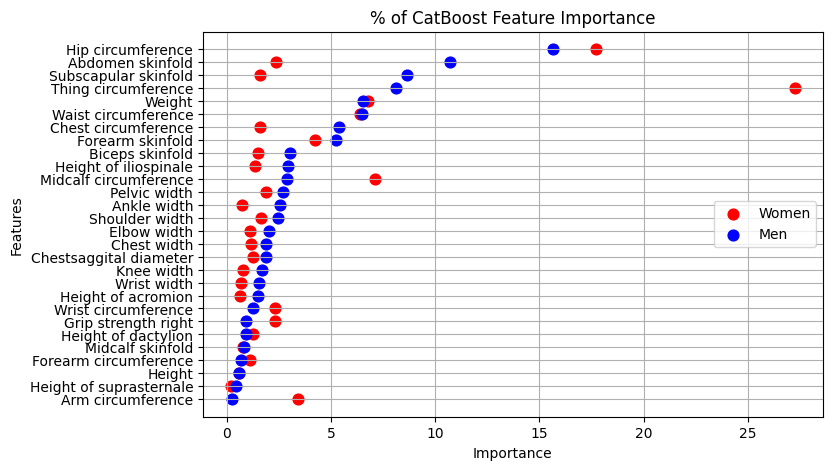

In [24]:
importances_w = model_w.get_feature_importance(type='PredictionValuesChange')
importances_m = model_m.get_feature_importance(type='PredictionValuesChange')
feature_importances = pd.DataFrame({'Women': importances_w,
                                    'Men': importances_m},
                                     index=col_name).sort_values(by='Men', ascending=True)
display(feature_importances)
plt.figure(figsize=(8, 5))

plt.scatter(x = feature_importances['Women'],
             y = feature_importances.index,
             c='red',
             s=60)
plt.scatter(x = feature_importances['Men'],
             y = feature_importances.index,
             c='blue',
             s=60)
plt.title('% of CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.grid()
plt.legend(['Women', 'Men'], loc = 'center right')
plt.show()

In [25]:
'''# Save models
model_w.save_model('model_w_906_.bin')
model_m.save_model('model_m_904_.bin')'''

#### Shapley Value (SHAP) assessment of the significance of features using the SHAP method

[Documentation](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Catboost%20tutorial.html)

The built-in assessment of the influence of features on model predictions is not accurate enough, since it does not take into account the fact that features can influence not only individually, but also in combination with other features. Classical approaches for modeling the proportion of fat mass or body composition often use various combinations of features, including quite complex mathematical formulas. Therefore, assessing the contribution of individual features to the developed model does not provide an accurate understanding of the degree of influence of this feature. To accurately estimate the contribution of features to the predicted values of the model, the Shapley Value algorithm (SHAP) was proposed [1](https://www.nature.com/articles/s42256-019-0138-9), [2](https://papers.nips.cc/paper_files/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html). It evaluates how strongly each feature determines the result of calculating a function in any combination with other features included in the model.
SHAP values for CatBoost explain the range of body fat percentage estimates. Below we see that the main factor behind the large proportion of fat mass according to the model is body weight. The next most important indicator is hip circumference in women and waist circumference in men.

In [26]:
df_Xw_test = pd.DataFrame(data = Xw_test_st,
                  columns=col_name)
df_Xw_train = pd.DataFrame(data = Xw_train_st,
                  columns=col_name)
Xw = pd.concat([df_Xw_test, df_Xw_train], ignore_index=True)
print(Xw.shape, df_Xw_test.shape, df_Xw_train.shape)
#Xw.columns = col_name_
display(Xw.head())

df_Xm_test = pd.DataFrame(data = Xm_test_st,
                  columns=col_name)
df_Xm_train = pd.DataFrame(data = Xm_train_st,
                  columns=col_name)
Xm = pd.concat([df_Xm_test, df_Xm_train], ignore_index=True)
#Xm.columns = col_name_
print(Xm.shape, df_Xm_test.shape, df_Xm_train.shape)
display(Xm.head())

(282, 28) (57, 28) (225, 28)


Weight  Height  Height of suprasternale  Height of acromion  \
0    59.0   161.2                    130.2               131.4   
1    56.7   159.7                    128.2               127.6   
2    55.5   169.3                    138.0               137.1   
3    57.2   171.6                    139.5               138.8   
4    51.5   161.4                    131.3               131.4   

   Height of dactylion  Height of iliospinale  Shoulder width  Chest width  \
0                 60.0                   91.7            36.5         25.6   
1                 59.0                   91.0            36.0         25.7   
2                 62.5                   94.6            37.6         23.8   
3                 63.8                   96.5            38.1         24.2   
4                 64.9                   87.2            32.7         22.0   

   Pelvic width  Chestsaggital diameter  ...  Subscapular skinfold  \
0          29.5                    16.8  ...                  11.0   
1          25.9                    17.6  ...                  13.2   
2          28.3                    17.3  ...                   NaN   
3          29.0                    15.7  ...                   9.4   
4          25.1                    12.8  ...                   9.2   

   Biceps skinfold  Forearm skinfold  Abdomen skinfold  Midcalf skinfold  \
0             18.2               7.0              21.2              20.0   
1              NaN              12.0               NaN              14.1   
2              NaN               NaN               NaN               NaN   
3              NaN               6.2              13.4              12.8   
4             11.0               8.8              20.8              10.6   

   Elbow width  Wrist width  Knee width  Ankle width  Grip strength right  
0         61.0         46.0        86.0         61.0                 22.0  
1         60.0         49.0        90.0         66.0                 26.0  
2         66.0         54.0        92.0         70.0                 28.0  
3         58.0         51.0        87.0         72.0                 38.0  
4         60.0         50.0        86.0         70.0                 22.0  

[5 rows x 28 columns]

(135, 28) (27, 28) (108, 28)


Weight  Height  Height of suprasternale  Height of acromion  \
0    82.7   175.6                    142.7               142.5   
1    68.5   182.3                    146.6               147.3   
2    77.3   181.2                    146.9               145.9   
3    94.3   191.4                    157.4               157.5   
4    74.7   182.1                    147.7               148.6   

   Height of dactylion  Height of iliospinale  Shoulder width  Chest width  \
0                 63.9                   98.9            35.5         26.4   
1                 66.2                  103.2            43.1         27.6   
2                 68.0                  101.4            40.0         29.0   
3                 75.8                  108.0            44.2         29.8   
4                 67.9                  104.3            37.5         25.2   

   Pelvic width  Chestsaggital diameter  ...  Subscapular skinfold  \
0          27.5                    18.4  ...                  15.6   
1          27.0                    19.0  ...                   8.0   
2          28.7                    18.5  ...                   9.6   
3          32.0                    21.0  ...                  22.4   
4          25.7                    17.9  ...                  10.0   

   Biceps skinfold  Forearm skinfold  Abdomen skinfold  Midcalf skinfold  \
0             13.4              10.2              18.2              15.0   
1             10.2               7.0               9.4              14.2   
2             12.8              13.2              11.4              15.2   
3              NaN              14.8              26.0               NaN   
4             13.6               6.6              17.2              15.0   

   Elbow width  Wrist width  Knee width  Ankle width  Grip strength right  
0         74.0         57.0        97.0         74.0                 55.0  
1         71.0         53.0        95.0         73.0                 50.0  
2         73.0         66.0       106.0         80.0                  NaN  
3         70.0         61.0       100.0         75.0                 50.0  
4         72.0         58.0        99.0         80.0                 48.0  

[5 rows x 28 columns]

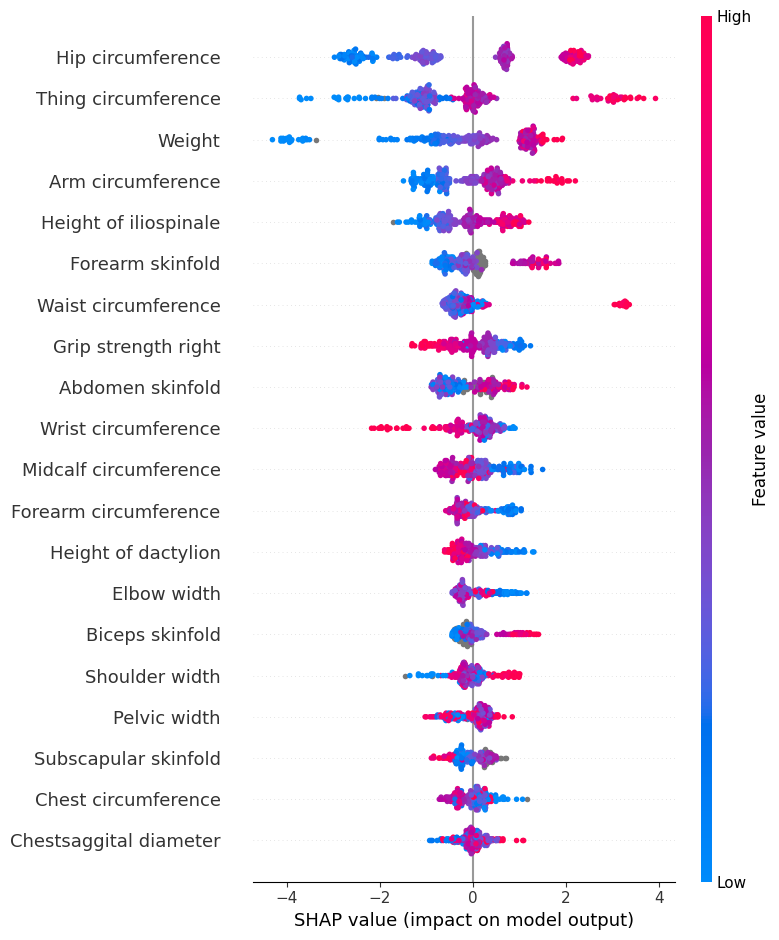

In [30]:
shap_values_w = shap.TreeExplainer(model_w).shap_values(Xw)
shap.summary_plot(shap_values_w, Xw)

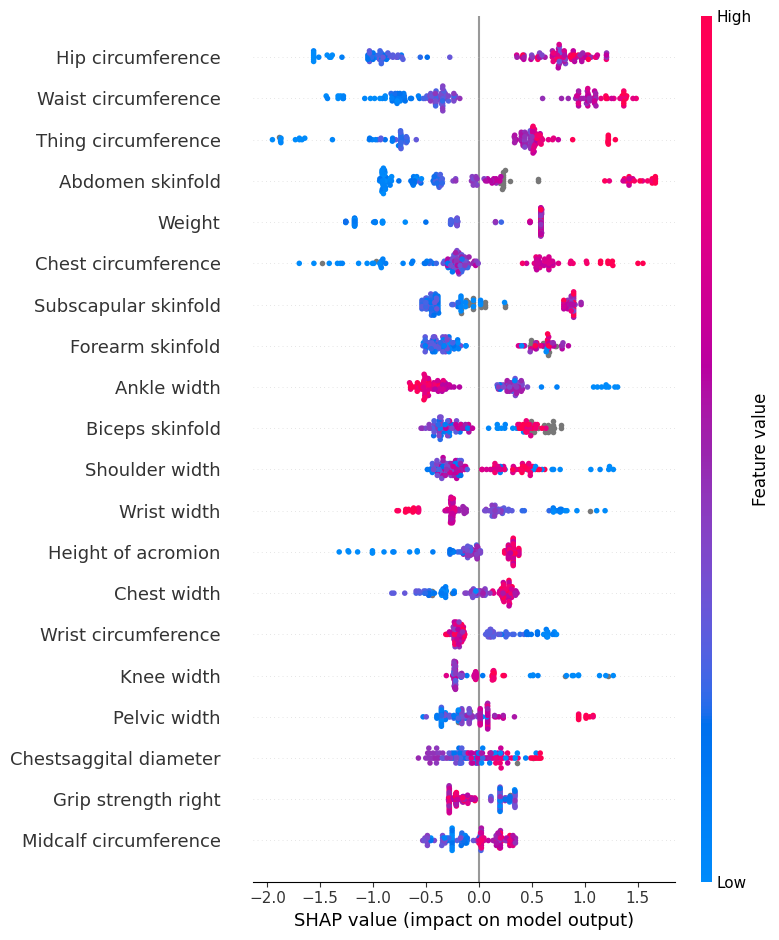

In [31]:
shap_values_m = shap.TreeExplainer(model_m).shap_values(Xm)
shap.summary_plot(shap_values_m, Xm)

This summary plot replaces the typical bar chart of feature importance. It tells which features are most important, and also their range of effects over the dataset. The color allows us match how changes in the value of a feature effect the change fatmass share. Note that every dot is a person. 

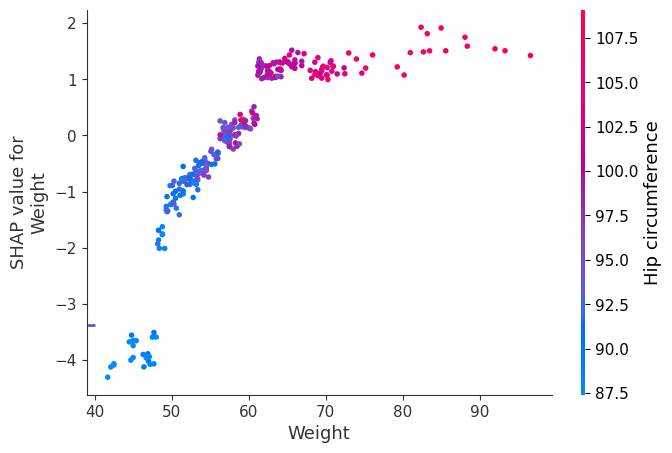

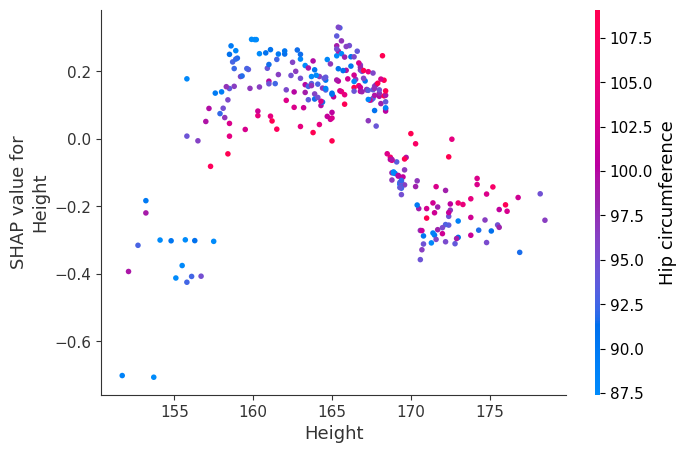

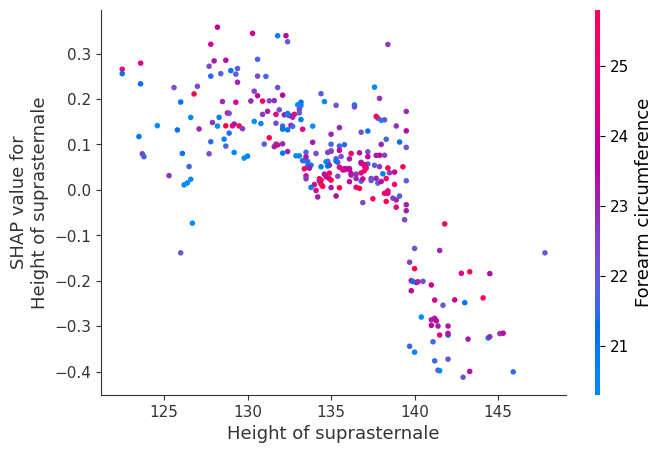

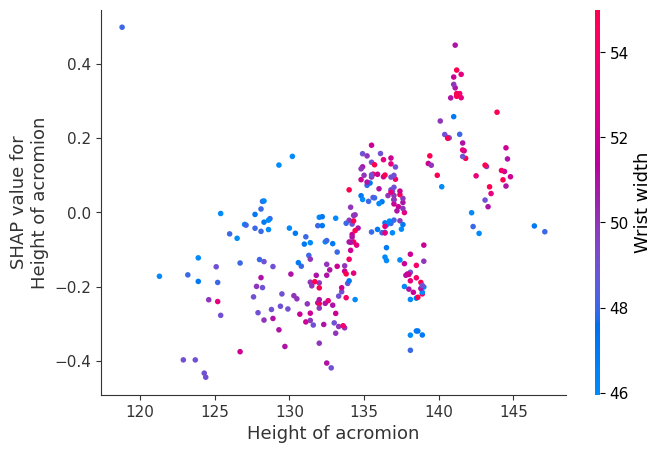

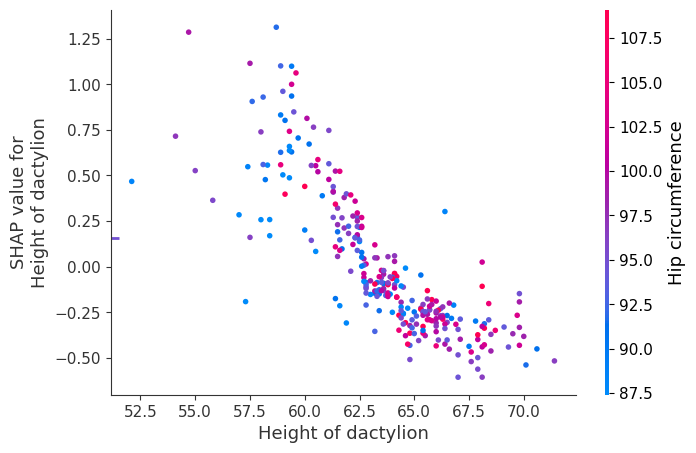

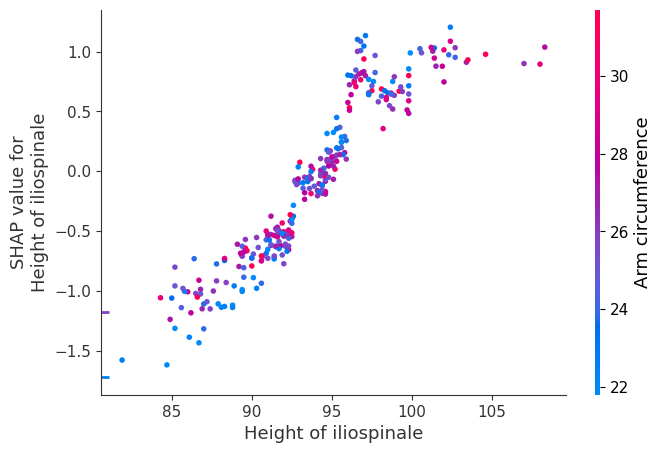

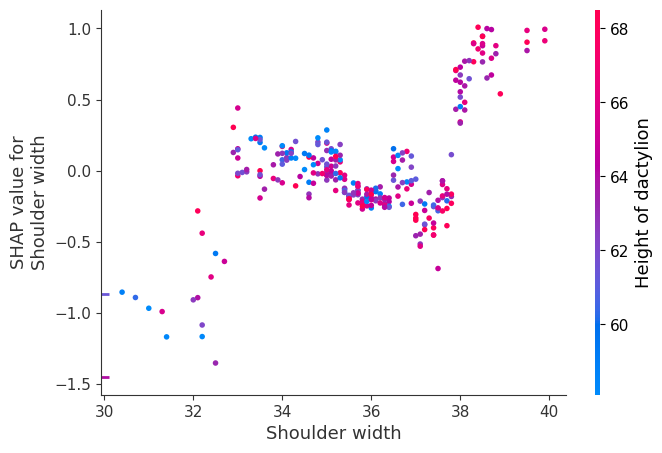

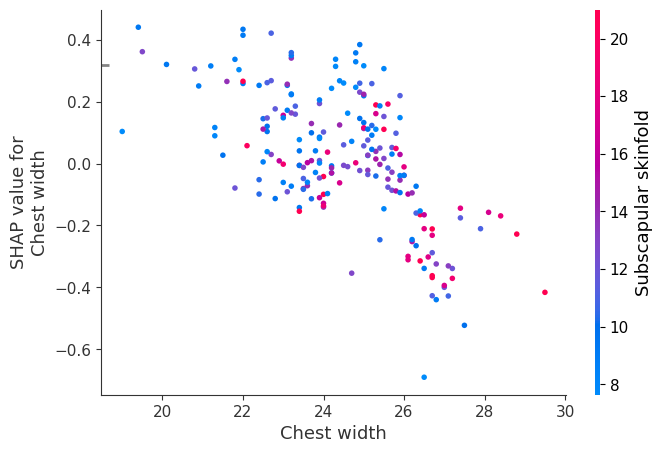

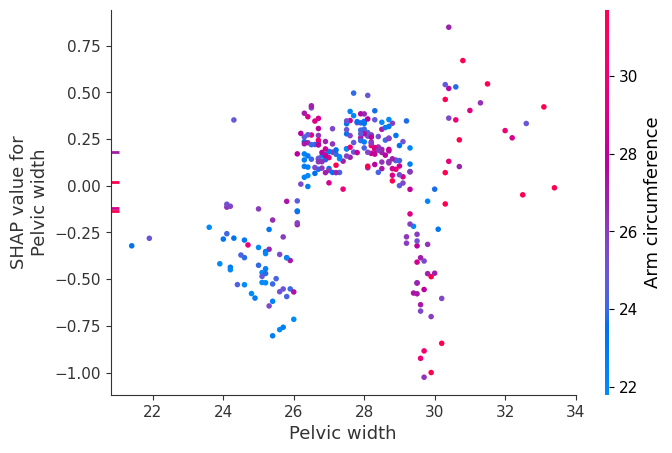

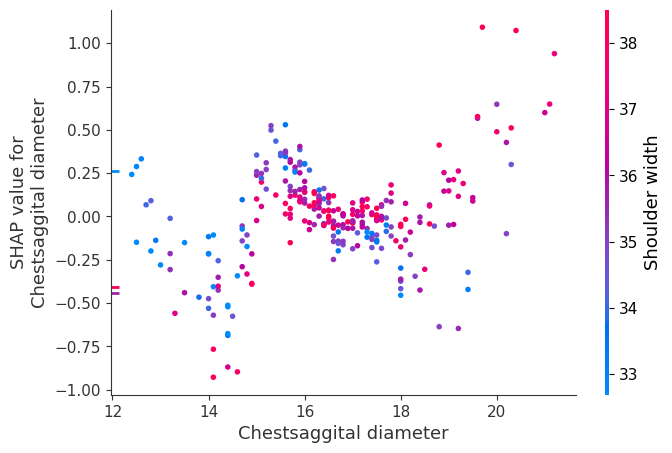

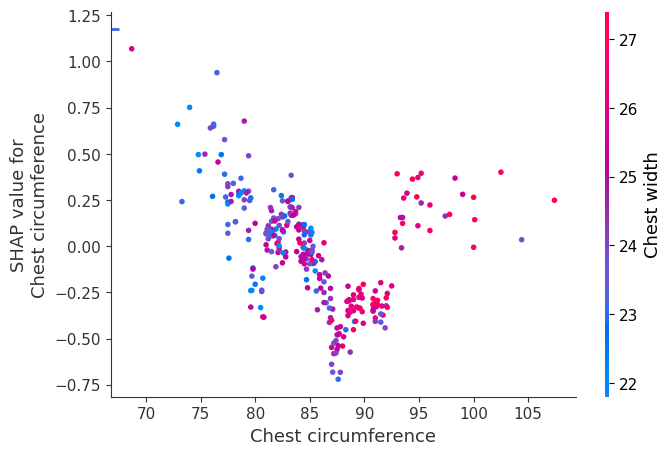

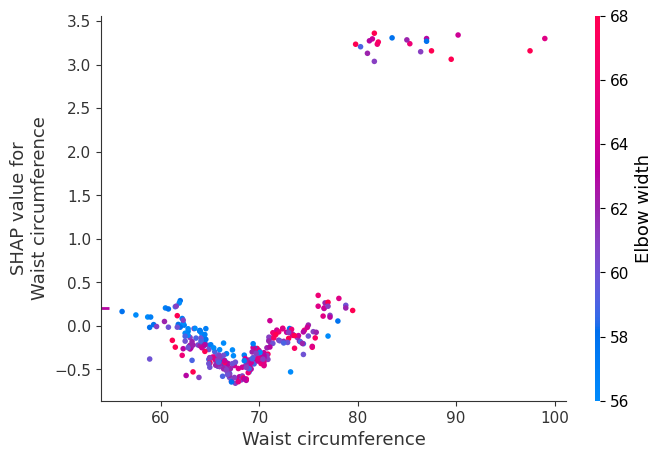

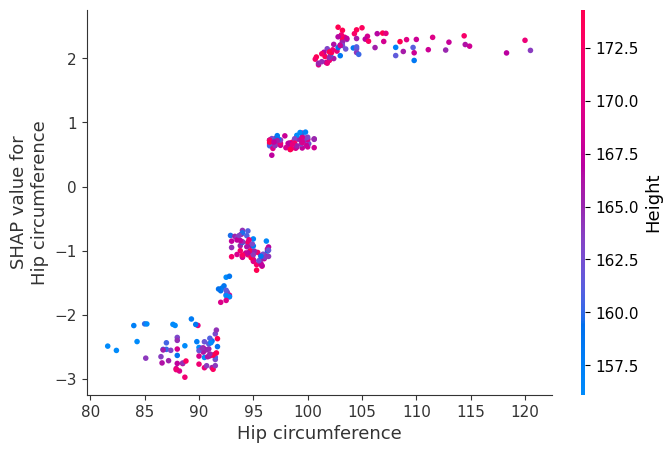

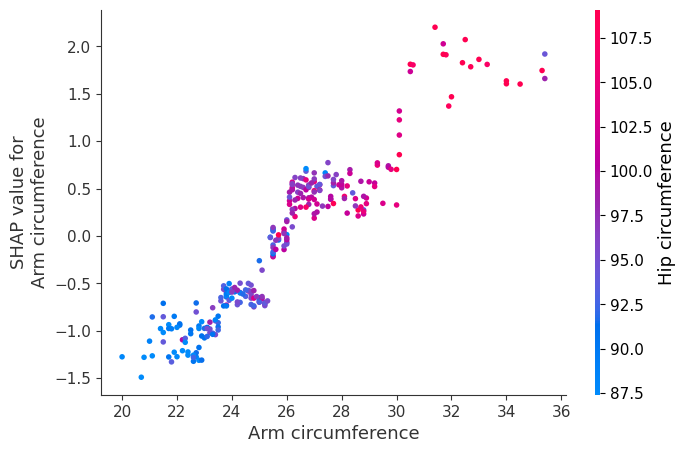

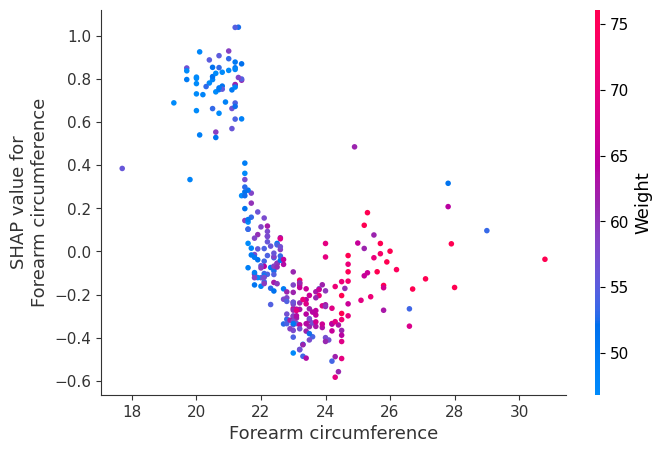

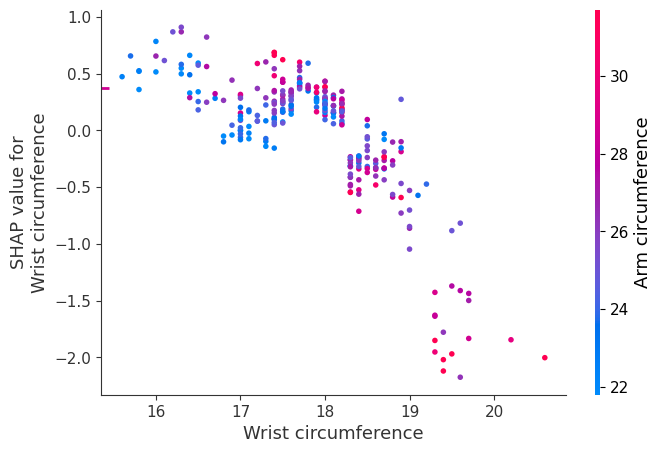

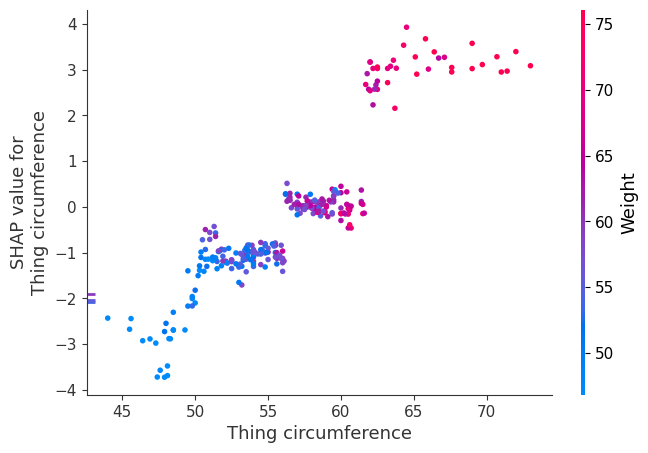

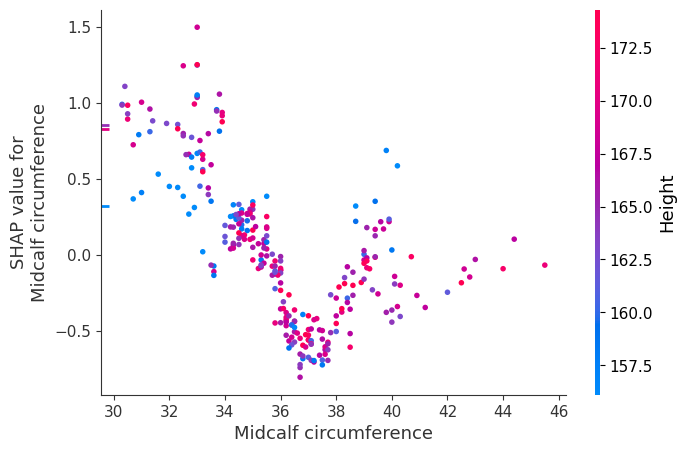

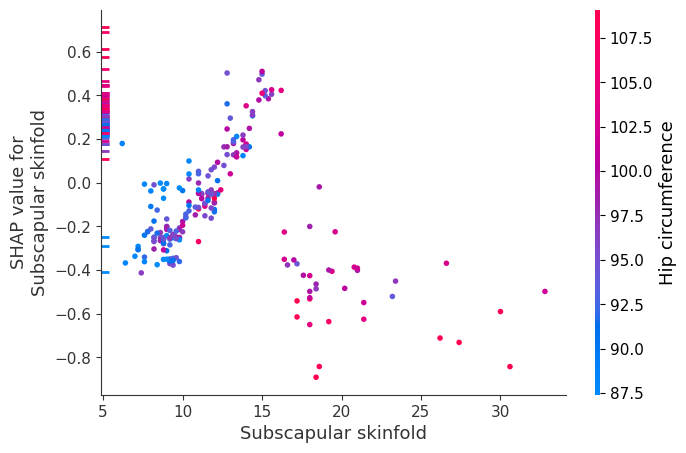

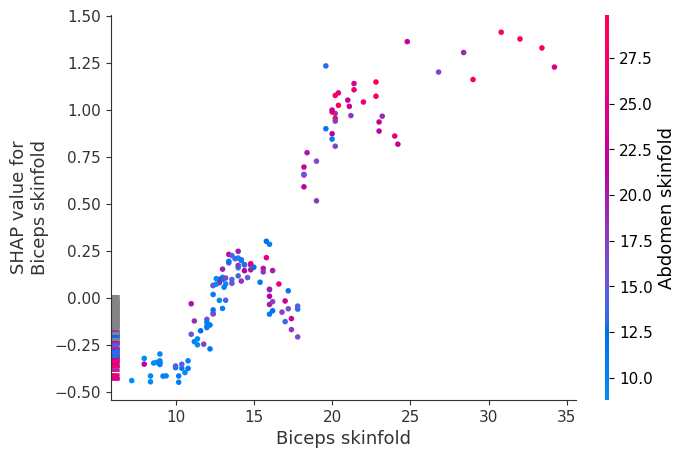

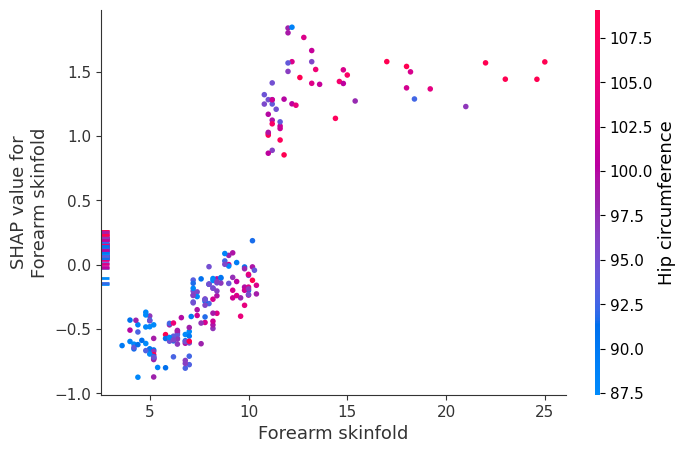

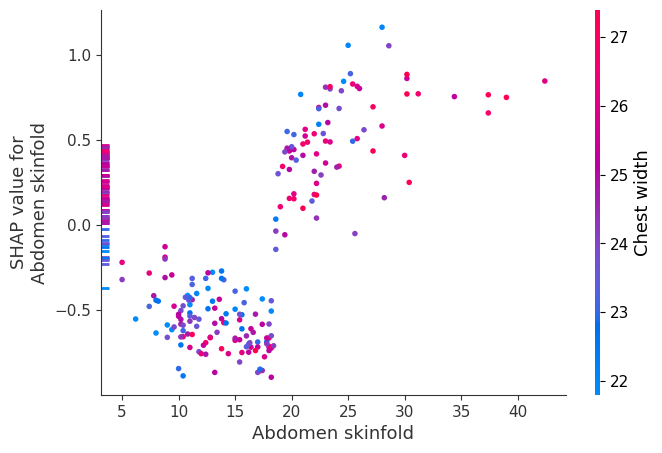

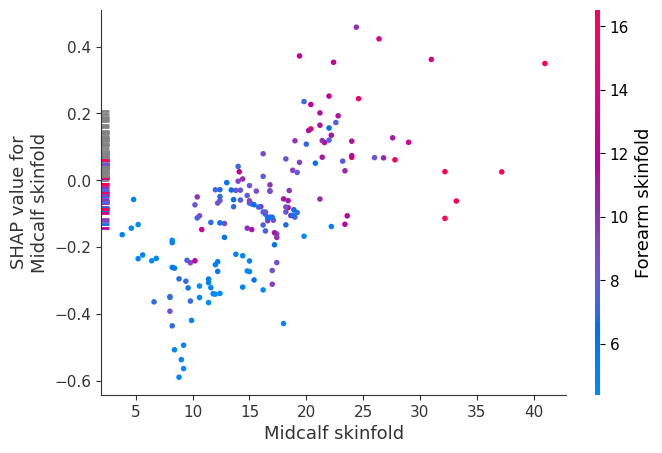

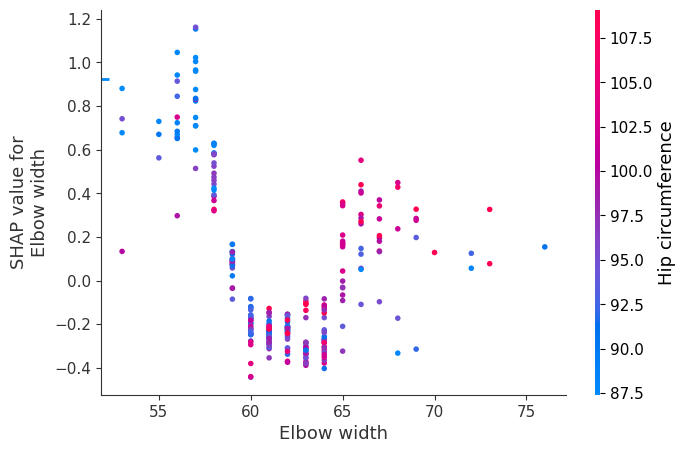

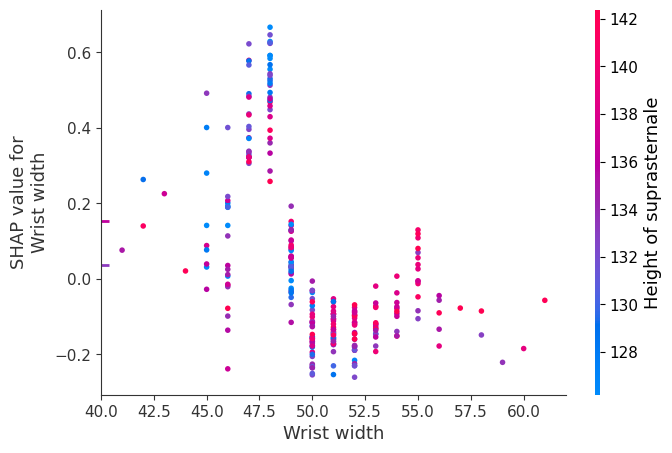

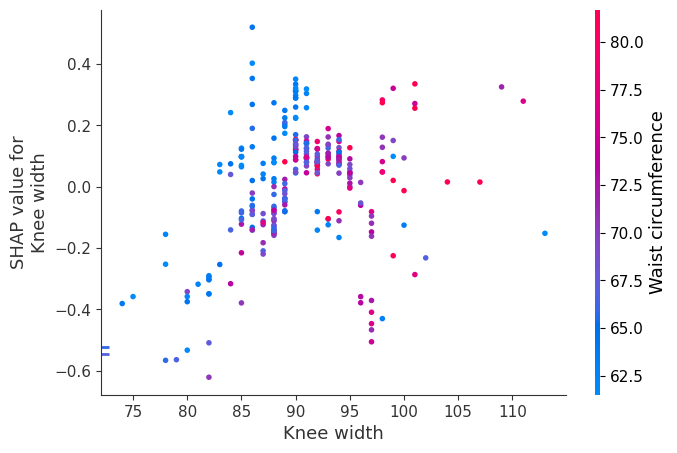

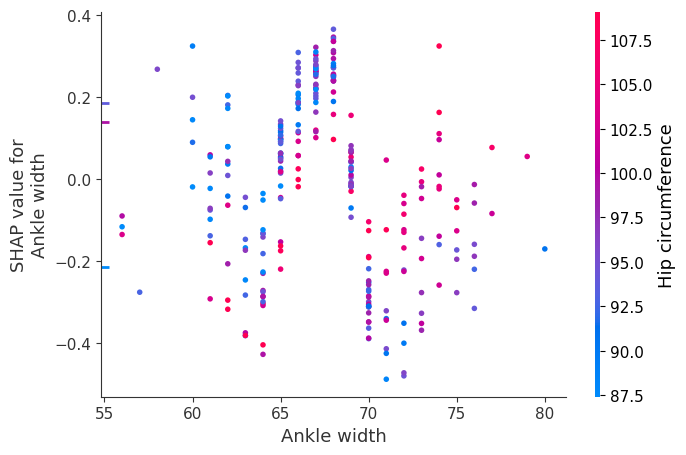

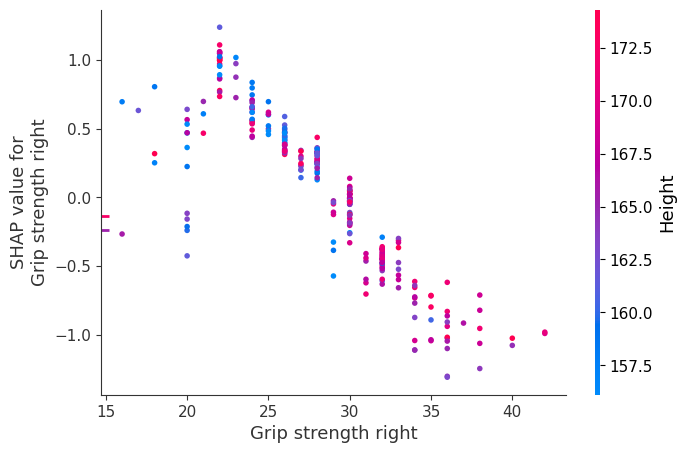

In [33]:
for col in col_name: 
    shap.dependence_plot(col, shap_values_w, Xw)
    plt.show()

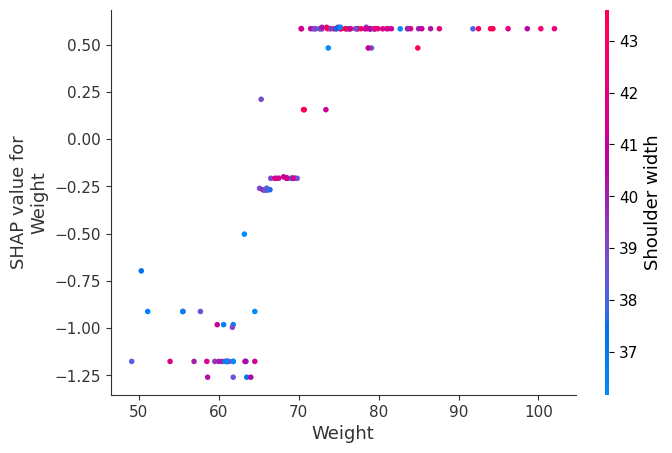

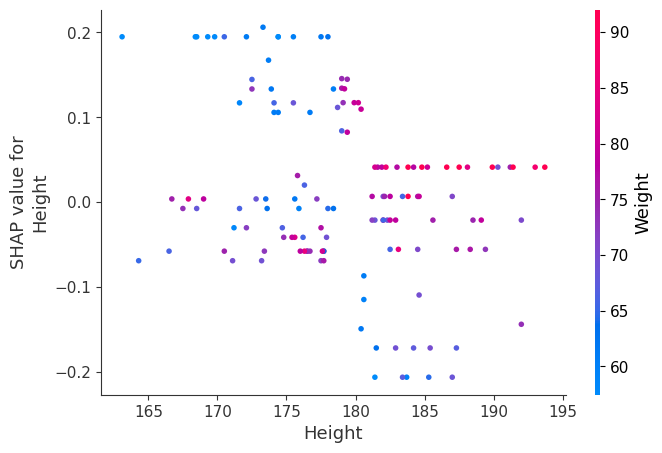

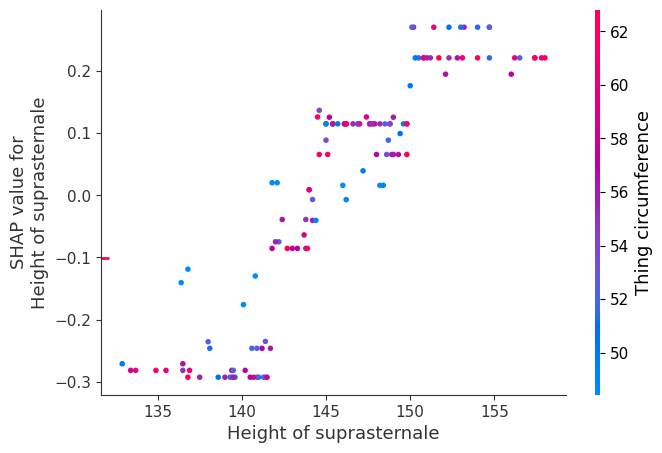

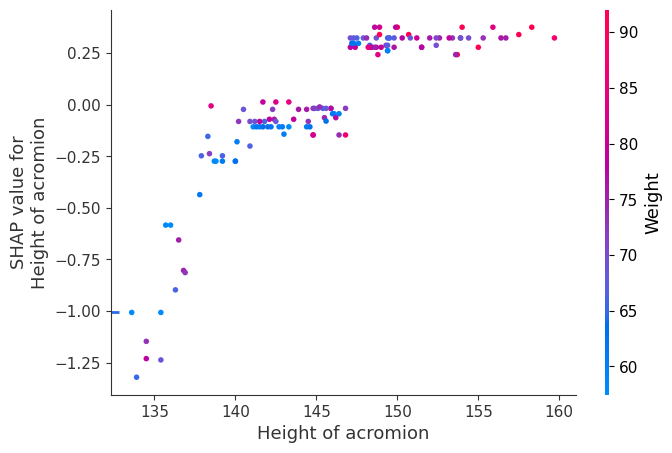

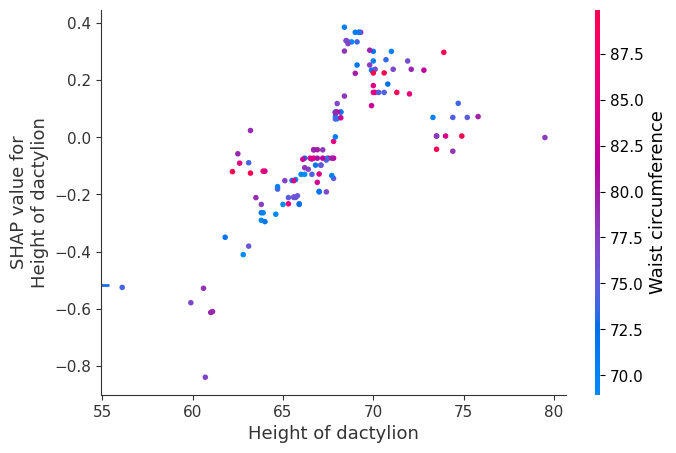

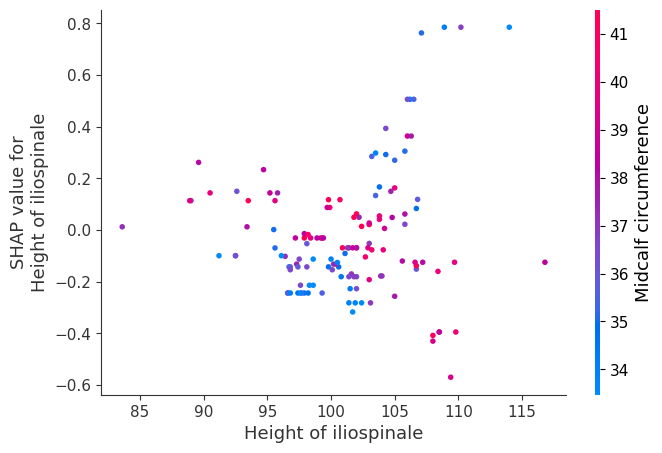

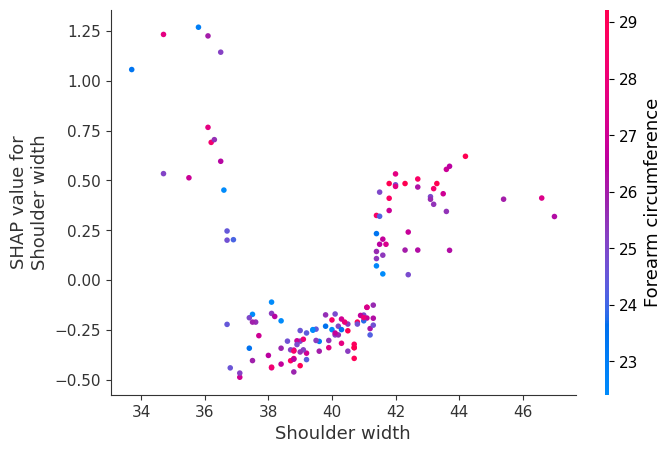

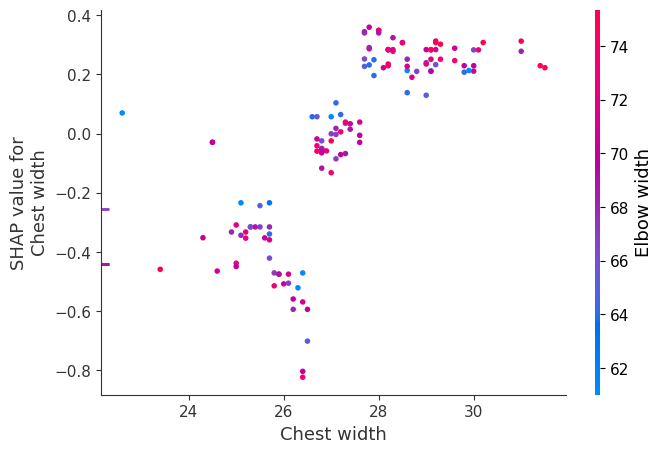

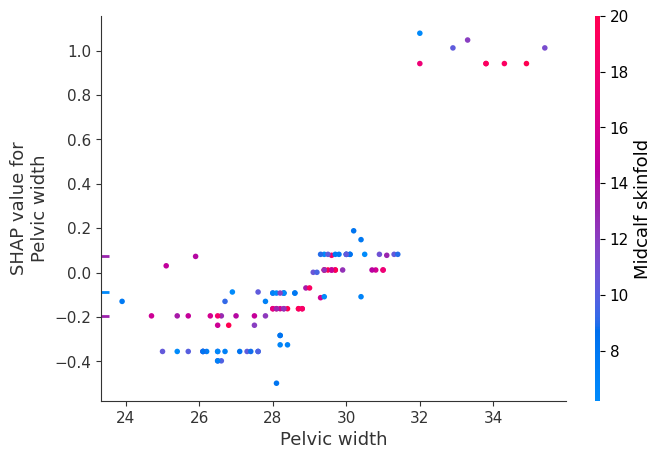

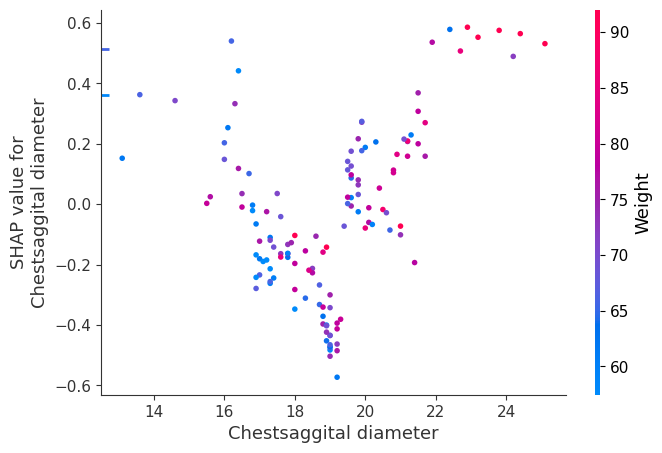

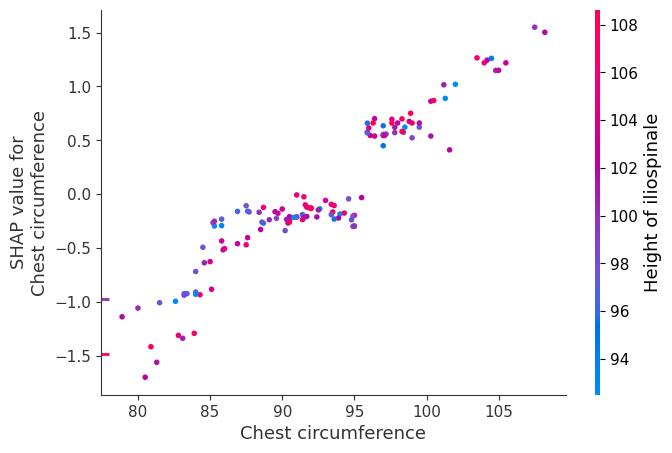

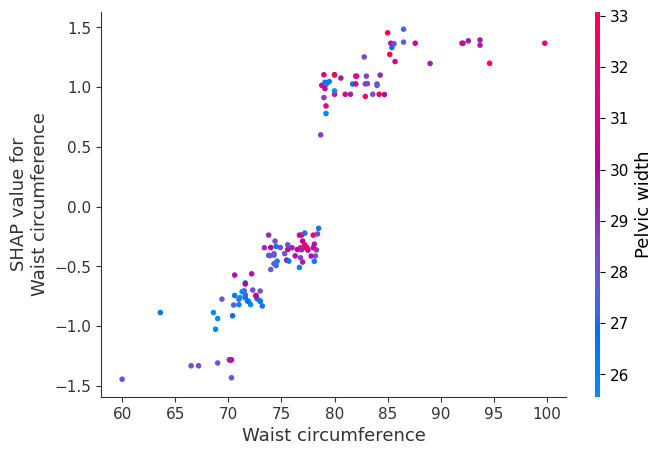

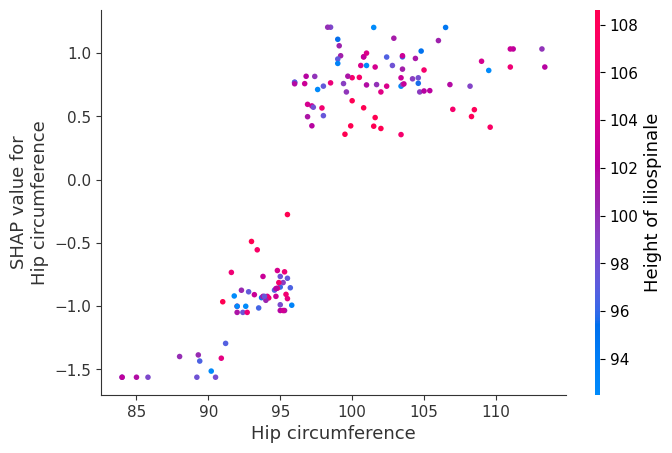

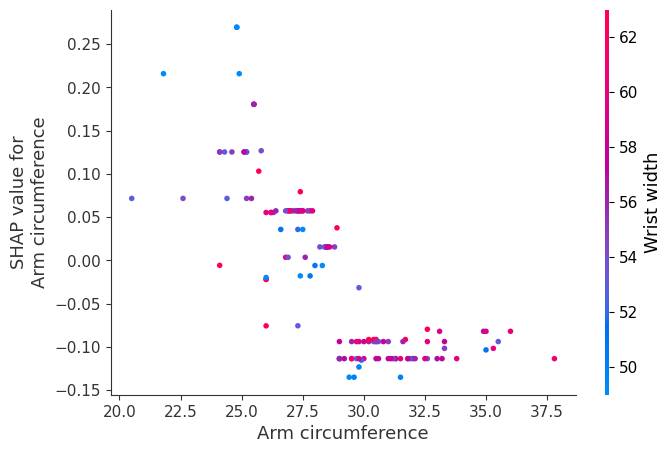

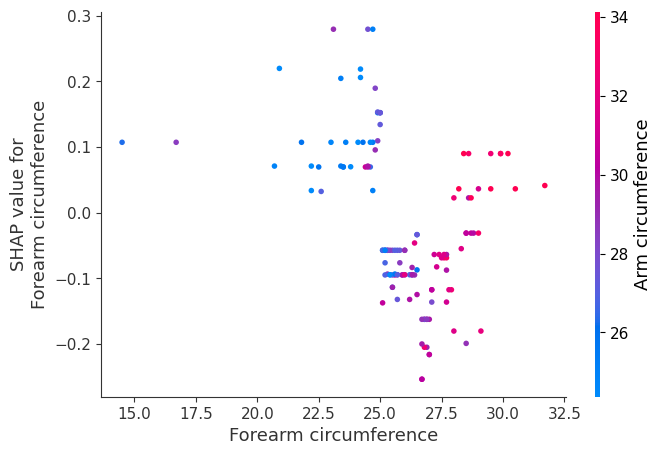

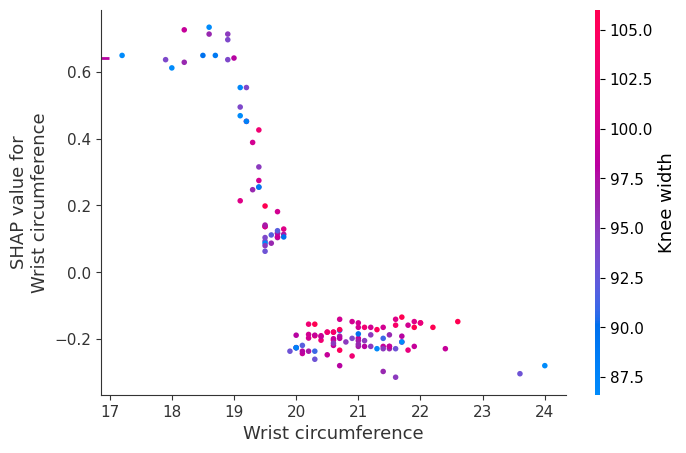

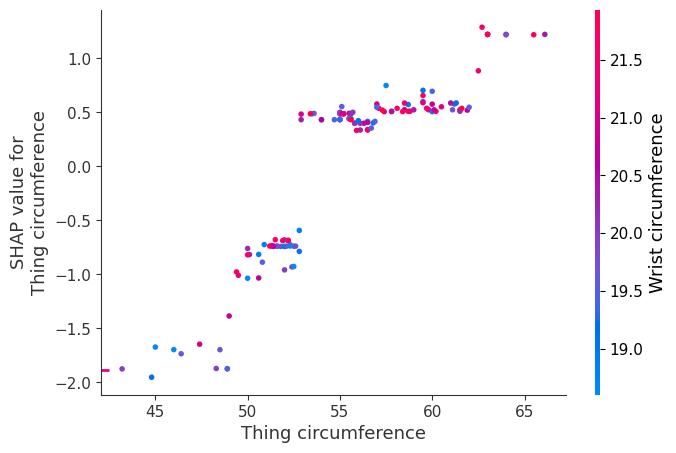

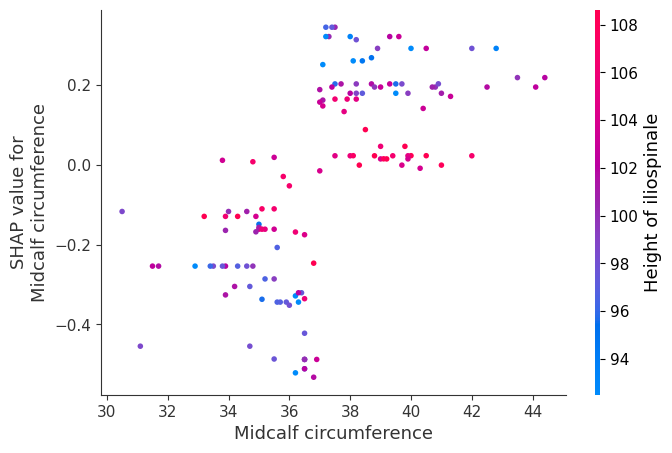

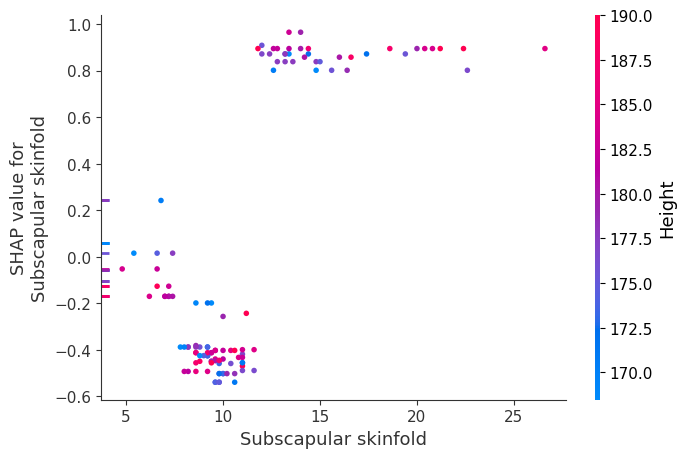

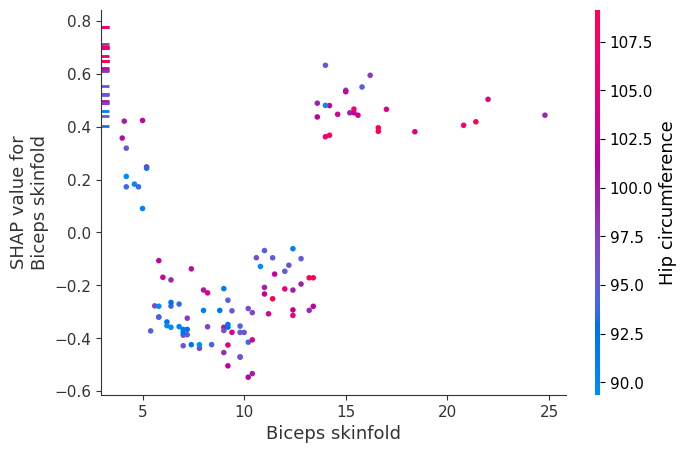

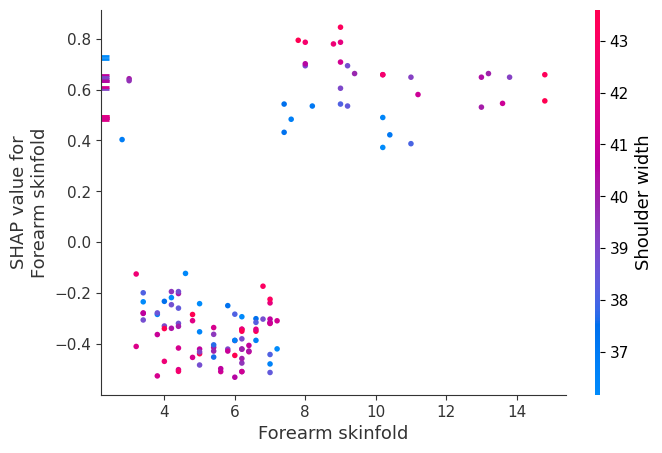

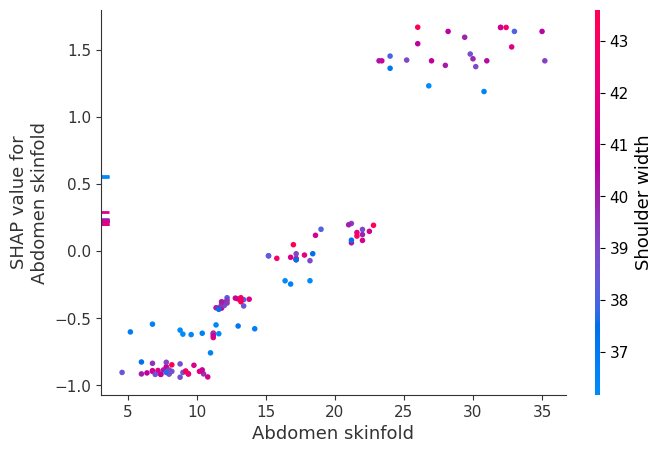

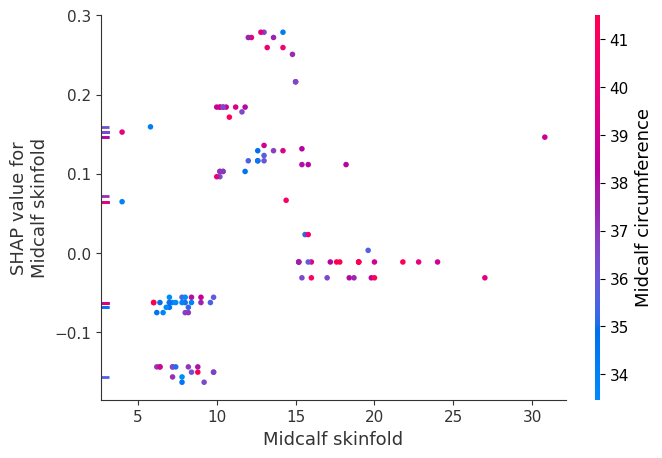

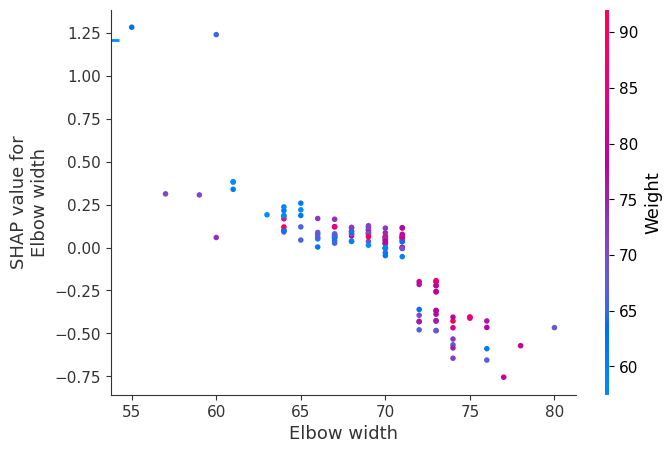

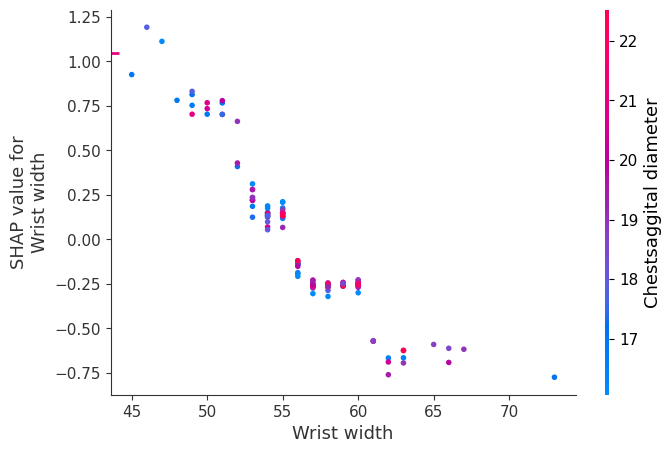

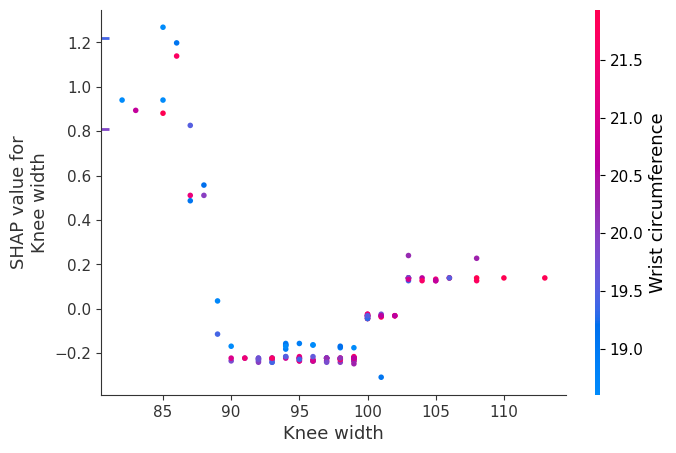

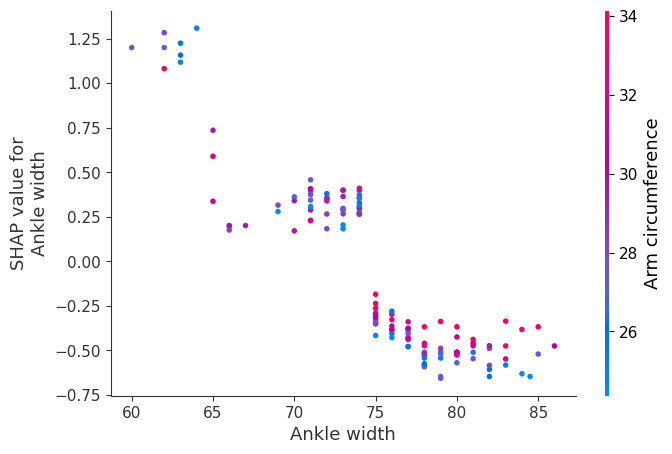

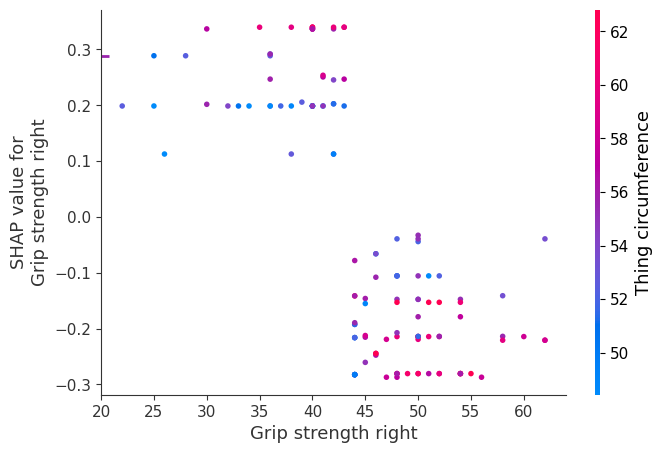

In [34]:
for col in col_name: 
    shap.dependence_plot(col, shap_values_m, Xm)
    plt.show()

### Bland-Altman plot

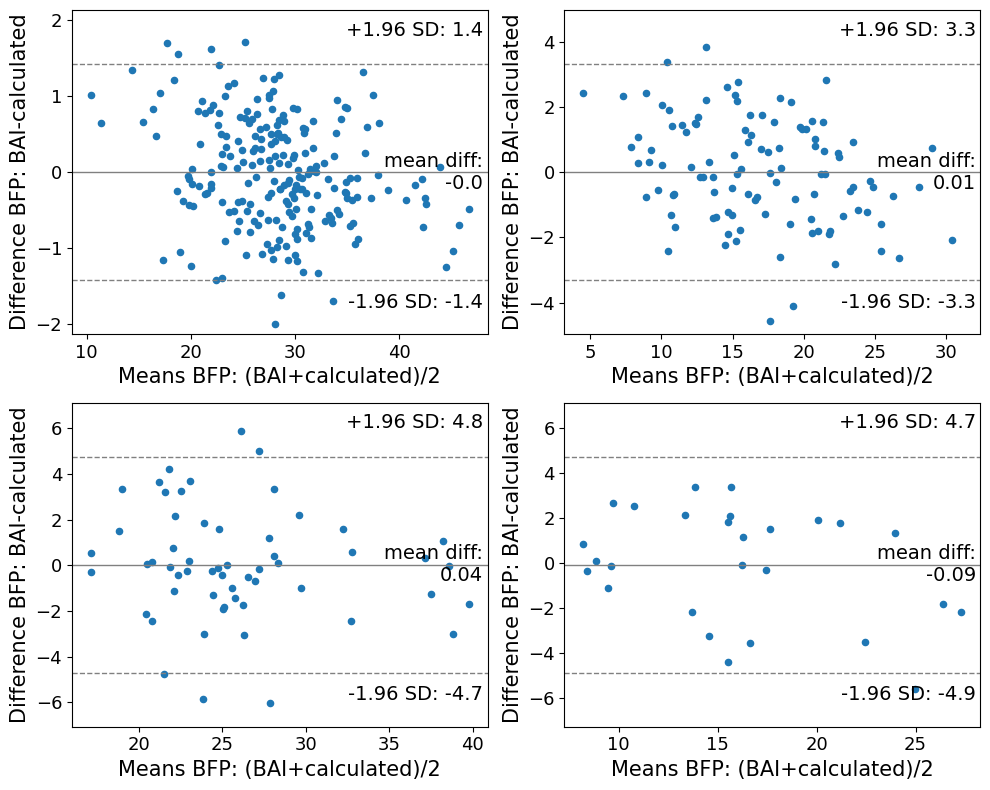

In [37]:
#create Bland-Altman plot
import statsmodels.api as sm

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
 
#fig.suptitle(f'Женщины: {f_1}, {f_2}, {f_3} /n ')
  
sm.graphics.mean_diff_plot (yw_pred_train, yw_train, ax=axes[0, 0])
sm.graphics.mean_diff_plot (ym_pred_train, ym_train, ax=axes[0, 1])
sm.graphics.mean_diff_plot (yw_pred_test, yw_test, ax=axes[1, 0])
sm.graphics.mean_diff_plot (ym_pred_test, ym_test, ax=axes[1, 1])

axes[0,0].set_xlabel('Means BFP: (BAI+calculated)/2')
axes[1,0].set_xlabel('Means BFP: (BAI+calculated)/2')
axes[0,1].set_xlabel('Means BFP: (BAI+calculated)/2')
axes[1,1].set_xlabel('Means BFP: (BAI+calculated)/2')

axes[0,0].set_ylabel('Difference BFP: BAI-calculated')
axes[1,0].set_ylabel('Difference BFP: BAI-calculated')
axes[0,1].set_ylabel('Difference BFP: BAI-calculated')
axes[1,1].set_ylabel('Difference BFP: BAI-calculated')

plt.show()